# CBP transmission

The goal of this notebook is to comput the CBP transmission curve.

In [3]:
import os, sys
print(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy import constants as const
from astropy import units as u
from scipy.interpolate import interp1d

from solarcell_dataset import SolarCellDataSet, SolarCellRun, calculate_npulses, get_info_from_filename
%matplotlib notebook

/home/jneveu/stardice/analysis/cbp_paper


Solar cell data run :

In [4]:
data_dir = "/data/STARDICE/cbp/solarcell/ut20210719"
other_str = "Angle_0"
nbursts = 5

run = SolarCellRun(directory_path=data_dir, tag=other_str, nbursts=nbursts)
run.load_from_file(os.path.join(data_dir, f"QSWMax_EMPTY_Angle_0_ntuple.npy"))
nt = run.data

run2 = SolarCellRun(directory_path=data_dir, tag=other_str, nbursts=nbursts)
run2.load_from_file(os.path.join(data_dir, f"QSWMax_EMPTY_Angle_0_ntuple_old20210725.npy"))
nt2 = run2.data

Solar cell and photodiode quantum efficiencies :

<IPython.core.display.Javascript object>


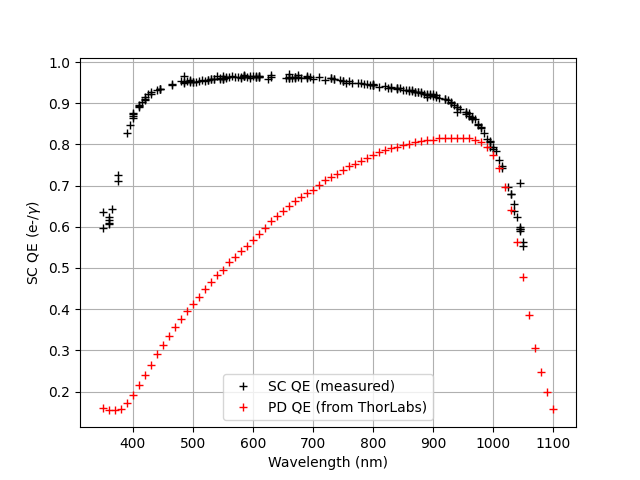

In [5]:
ref_data_root = "/data/STARDICE/cbp/solarcell/refCalData/"
SC_QE_data_file = ref_data_root + 'SC_QE_from_mono_SC_ED_20210618_MultiDay.txt'
PD_QE_data_file = ref_data_root + 'SM05PD1B_QE.csv'

SC_QE = np.loadtxt(SC_QE_data_file, skiprows=1, delimiter=",").T
PD_QE = np.loadtxt(PD_QE_data_file, skiprows=1, delimiter=",").T

# PD_QE is in A/W units, convert it to e-/photons as SC_QE
PD_QE[1] *= (const.h * const.c / (PD_QE[0] * 1e-9 * u.meter * const.e.value)).value

SC_QE_f = interp1d(SC_QE[0], SC_QE[1], bounds_error=False, fill_value=np.min(SC_QE[1]))
PD_QE_f = interp1d(PD_QE[0], PD_QE[1], bounds_error=False, fill_value=np.min(PD_QE[1]))

#Make plots of the background data that we used in our measurements
fig = plt.figure()
SC_QE_plot = plt.plot(SC_QE[0], SC_QE[1], 'k+', label='SC QE (measured)')
PD_QE_plot = plt.plot(PD_QE[0], PD_QE[1], 'r+', label='PD QE (from ThorLabs)')
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'SC QE (e-/$\gamma$)')
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


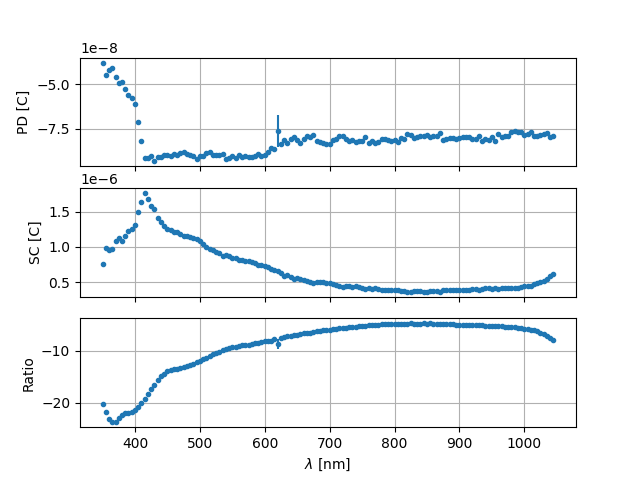

In [6]:
run.plot_summary()

CBP transmission :

<IPython.core.display.Javascript object>


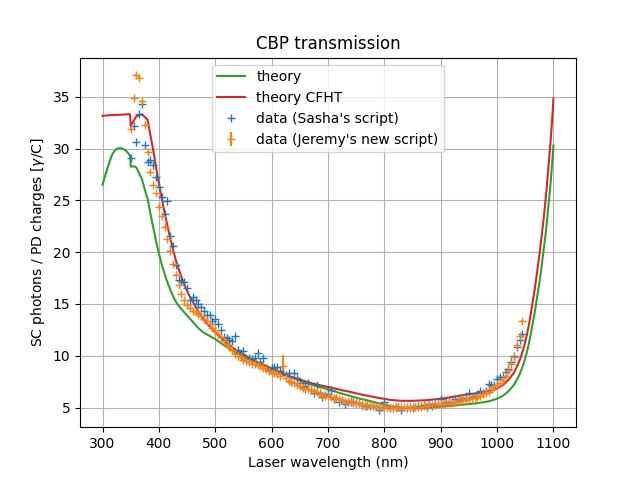

In [7]:
csv = np.loadtxt(os.path.join(data_dir, "QSWMax_EMPTY_Angle0SC_photons_over_PD_electrons.txt"), skiprows=1, delimiter=",")

wl, tr, tr_err = run.get_SC_photons_over_PD_charges(plot=False)

double_Al_wavelength, double_Al_responsivity = np.loadtxt(os.path.join(ref_data_root, 'TwoBounceAl.dat'), delimiter=',', skiprows=1).T
Al_wl, Al_CFHT = np.loadtxt(os.path.join(ref_data_root, 'CFHT_Primary_Transmission.dat'), delimiter=' ', skiprows=0).T
Al_wl *= 0.1
Al_CFHT *= Al_CFHT

fig = plt.figure()
plt.errorbar(csv.T[0], csv.T[1], marker='+', linestyle="none", label="data (Sasha's script)")
plt.errorbar(run.data["set_wl"], tr, yerr=tr_err, marker='+', linestyle="none", label="data (Jeremy's new script)")
plt.plot(double_Al_wavelength, 6*double_Al_responsivity / PD_QE_f(double_Al_wavelength), '-', label="theory")
plt.plot(Al_wl, 6*Al_CFHT / PD_QE_f(Al_wl), '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD charges [$\gamma$/C]')
plt.grid()
plt.title("CBP transmission")
plt.legend()
plt.show()



Photon ratio :

In [8]:
np.save("cbp_transmission.npy", [run.data["set_wl"], tr, tr_err])

<IPython.core.display.Javascript object>


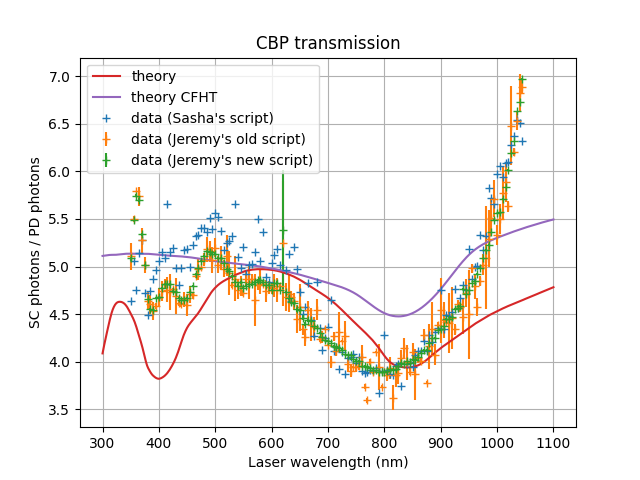

In [9]:
csv = np.loadtxt(os.path.join(data_dir, "QSWMax_EMPTY_Angle0SC_photons_over_PD_photons.txt"), skiprows=1, delimiter=",")

wl, tr, tr_err = run.get_SC_photons_over_PD_photons(plot=False)
wl, tr2, tr2_err = run2.get_SC_photons_over_PD_photons(plot=False)

fig = plt.figure()
plt.errorbar(csv.T[0], csv.T[1], marker='+', linestyle="none", label="data (Sasha's script)")
plt.errorbar(run2.data["set_wl"], tr2, yerr=tr2_err, marker='+', linestyle="none", label="data (Jeremy's old script)")
plt.errorbar(run.data["set_wl"], tr, yerr=tr_err, marker='+', linestyle="none", label="data (Jeremy's new script)")
plt.plot(double_Al_wavelength, 6*double_Al_responsivity, '-', label="theory")
plt.plot(Al_wl, 6*Al_CFHT, '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD photons')
plt.title("CBP transmission")
plt.grid()
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


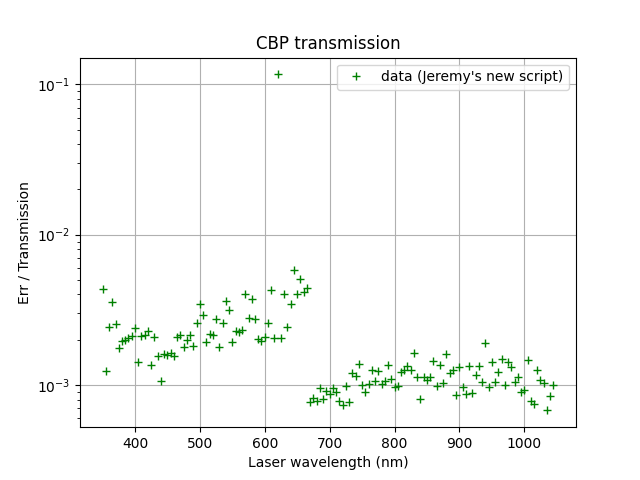

In [10]:
fig = plt.figure()
plt.plot(run.data["set_wl"], tr_err/tr, color="g", marker='+', linestyle="none", label="data (Jeremy's new script)")
plt.title("CBP transmission")
plt.grid()
plt.yscale("log")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('Err / Transmission')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


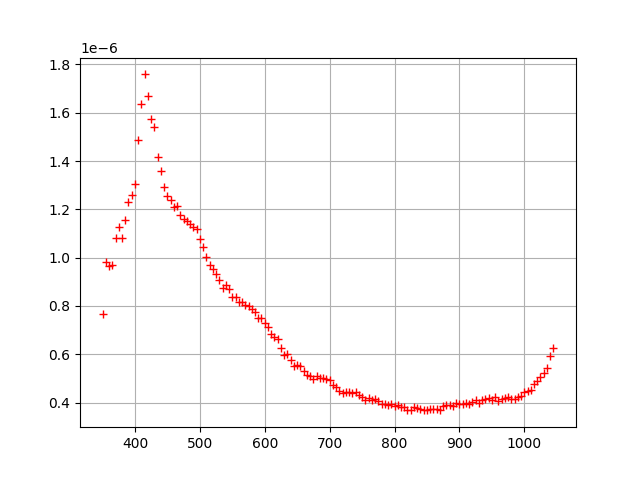

In [12]:
fig = plt.figure()
plt.plot(run.data["set_wl"], run.data["sc_charge_total"], 'r+')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


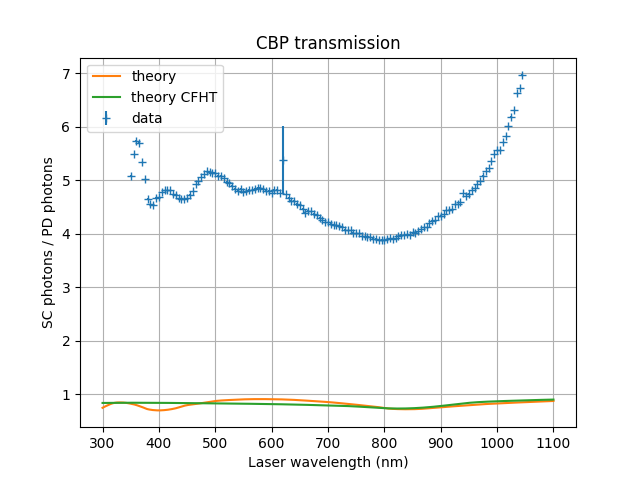

In [13]:
_ = run.get_SC_photons_over_PD_photons(plot=True)